Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0036
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 16/50
27/27 ━━━━━━━━━━━━

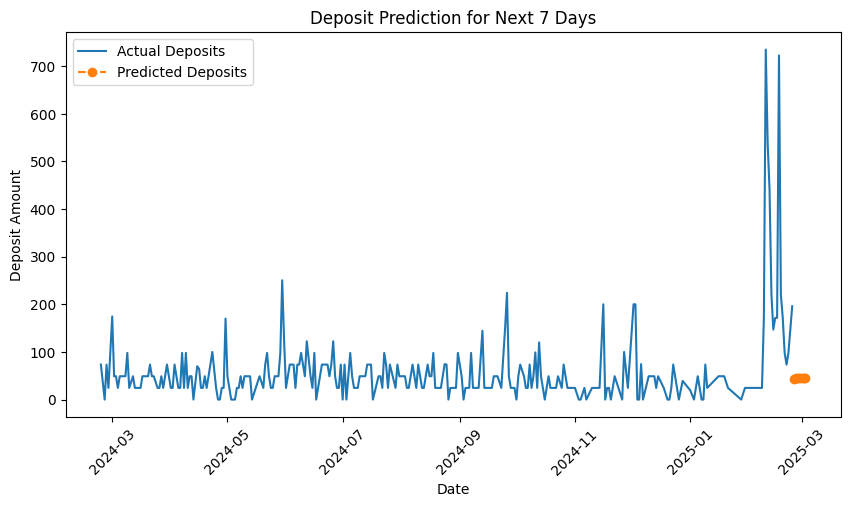

In [2]:
# Install dependencies (if not installed)
!pip install tensorflow pandas numpy scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set file path after uploading manually
file_path = "Statement.csv"  # Update this path after uploading

# Load dataset
df = pd.read_csv(file_path)

# Rename and select necessary columns
df.rename(columns={"თარიღი": "Date", "შემოსული თანხა": "Deposit"}, inplace=True)
df = df[["Date", "Deposit"]]

# Convert Date to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")

# Convert Deposit to numeric and fill NaN with 0
df["Deposit"] = pd.to_numeric(df["Deposit"], errors="coerce").fillna(0)

# Aggregate daily deposits
df_daily = df.groupby("Date")["Deposit"].sum().reset_index()

# Normalize data
scaler = MinMaxScaler()
df_daily["Deposit"] = scaler.fit_transform(df_daily[["Deposit"]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 7  # Use past 7 days to predict the next day
sequences, labels = create_sequences(df_daily["Deposit"].values, seq_length)

# Split data into training and testing sets
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation="relu"),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Predict the next 7 days
last_sequence = df_daily["Deposit"].values[-seq_length:].reshape(1, seq_length, 1)
predictions = []
for _ in range(7):
    pred = model.predict(last_sequence)[0][0]
    predictions.append(pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Generate future dates
future_dates = pd.date_range(df_daily["Date"].max() + pd.Timedelta(days=1), periods=7)

# Show forecasted deposits
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Deposit": predictions})
print(forecast_df)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(df_daily["Date"], scaler.inverse_transform(df_daily[["Deposit"]]), label="Actual Deposits")
plt.plot(forecast_df["Date"], forecast_df["Predicted Deposit"], marker="o", linestyle="dashed", label="Predicted Deposits")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Deposit Amount")
plt.title("Deposit Prediction for Next 7 Days")
plt.xticks(rotation=45)
plt.show()
